# Initialisation

In [176]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import json
import requests
import plotly.express as px
import matplotlib.pyplot as plt
from termcolor import colored                     # coloration du texte
from scipy import stats                           # lois de probabilité (valeurs extrêmes)
from scipy.stats import gumbel_r, genextreme      # valeurs extrêmes
from pyextremes import EVA                        # valeurs extrêmes  
from tabulate import tabulate                     # impression du texte dans un format tabulé
plt.rcParams['text.usetex'] = True                # paramètres latex


plt.rcParams['text.latex.preamble'] = '\\usepackage{libertine}'
plt.rcParams.update({
    "text.usetex": True,
    #"font.family": "Times New Roman",
    "font.family": "Linux Libertine",
    "font.size": 12
})
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)


from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#plt.style.use('default')

import arviz as az
import pymc as pm
import pymc_experimental.distributions as pmx
import pytensor.tensor as pt
from arviz.plots import plot_utils as azpu

################################
## Auteur : Christoophe Ancey ##
## Date : octobre 2024        ##
################################

#-------------------------------------------
# Fonctions 
#-------------------------------------------
def trouver_période_continue(liste):
    """ 
    fournit l'ensemble des sous-listes telles que chacun des éléments est séparé de l'élément par 1.
    Cette fonction permet de déterminer dans la série d'années avec des cumuls non nuls les séries continues
    d'années.
    """
    res, last = [[]], None
    for x in liste:
        if last is None or abs(last - x) ==1:
            res[-1].append(x)
        else:
            res.append([x])
        last = x
    return res

def Tracer_maxi(maxi,ax):
      na = len(maxi)
      maxi.sort()
      période = [(na+0.28)/(na-i-1+0.56) for i in range(na)]
      ax.scatter(période,maxi,  marker = "o",edgecolors='white', s=45, color='deepskyblue', alpha = 1)

def Trouver_maxi_annuels(série):
      maxi_valeur =  série.groupby(by=[série.index.year]).max().values
      maxi_date   =  série.groupby(by=[série.index.year]).max().index
      bloc_date   = []
      bloc_maxi   = []
      for i in range(len(maxi_date)): 
            selection =  série[(série==maxi_valeur[i]) & (série.index.year==maxi_date[i])] 
            date_occurrence = selection.index[0]
            valeur = selection.iloc[0]
            bloc_date.append(date_occurrence)
            bloc_maxi.append(valeur)
      série_max = pd.Series(bloc_maxi,index = bloc_date)
      return série_max, bloc_maxi   

def convertir_date(date,format='complet'):
    if format == 'simple':
        return datetime.datetime.strptime(date.to_string(index = False)  ,"%Y-%m-%d").strftime("%d/%m/%Y")
    else:
        return date.iloc[0].strftime('%Y-%m-%d')

In [156]:
import matplotlib as mpl
mpl.get_configdir()

'/home/ancey/.config/matplotlib'

In [158]:
mpl.get_cachedir()

'/home/ancey/.cache/matplotlib'

# Lecture des données

In [9]:
# adresse du fichier
# à changer selon besoin
base = '/home/ancey/Météo-France/postes/'

nom_choisi = "Val d'Isère"
répertoire_travail = base + "Val_D'Isere_Jos_73304005/safran/"
os.chdir(répertoire_travail)
précipitations      = pd.read_csv(répertoire_travail+'données_safran_neige.csv', sep="\t")
format_date_fichier = 'simple'
précipitations.date=pd.to_datetime(précipitations.date)
série_chute = pd.Series(np.array(précipitations['neige']),index=np.array(précipitations['date'])).squeeze()

In [157]:
série_chute 


1959-01-02     6.2
1959-01-03    10.5
1959-01-04     9.8
1959-01-05     3.9
1959-01-06    14.9
              ... 
2024-05-26     0.5
2024-05-27     8.5
2024-05-29     0.6
2024-05-30     2.4
2024-05-31     0.7
Length: 9852, dtype: float64

# Chronique des précipitations

Le maximum a été atteint le 2016-11-24 avec un cumul journalier de 208.4 mm.


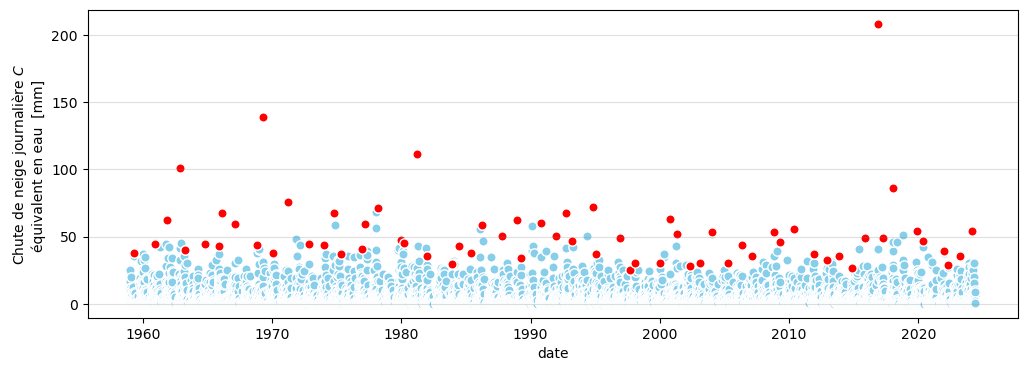

In [12]:
maxi_annuels_1j, maxi_annuels_val = Trouver_maxi_annuels(série_chute)

# distribution temporelle des distributions
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(précipitations['date'], précipitations["neige"] ,  marker = "o",edgecolors='white', s=45, color='skyblue', alpha = 1)
ax.set_ylabel(r'Chute de neige journalière $C$' +"\n"+ 'équivalent en eau  [mm] ')
ax.set_xlabel(r'date')
plt.grid(axis="y", color = 'gray', alpha = 0.25)
ax.scatter( maxi_annuels_1j.index,maxi_annuels_1j ,  marker = "o",edgecolors='white', s=45, color='red', alpha = 1)
date_max = précipitations[précipitations['neige']==np.nanmax(précipitations['neige'])]['date']
date_max = convertir_date(date_max)
print("Le maximum a été atteint le "+date_max+" avec un cumul journalier de {:.1f} mm.".format(np.nanmax(précipitations["neige"]))  )

# Calage d'une loi de valeurs extrêmes

In [15]:
# Calage par la méthode du maximum de vraisemblance
calage_gumbel = gumbel_r.fit(maxi_annuels_val)
calage_gev    = genextreme.fit(maxi_annuels_val)

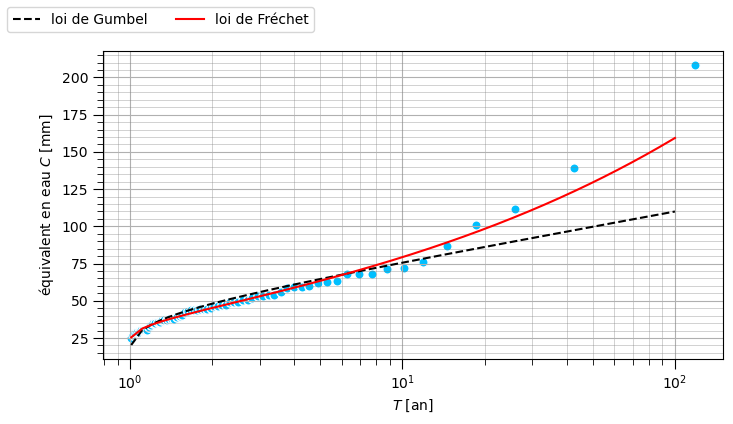

In [16]:
# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
(mu_g, sigma_g) = calage_gumbel

# Tracé

if xi>0:
      nom_loi = 'Fréchet'
else:
      nom_loi = 'Weibull'
période = np.linspace(1.01,100,1000)
quantile_gev  = lambda T:  mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
quantile_gumbel = lambda T: mu_g-sigma_g *np.log(-np.log(1-1/T) )

fig, axes = plt.subplots(figsize=(8,4))
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"équivalent en eau $C$ [mm]")
axes.grid()
axes.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=4)
plt.xscale('symlog', linthresh=1 )

axes.semilogx(période,quantile_gumbel(période),'--',color='black' , label = "loi de Gumbel")
axes.plot(période,quantile_gev(période),'-',color='red' , label = "loi de "+nom_loi)

Tracer_maxi(maxi_annuels_val,axes)
fig.legend(loc="upper left",ncol=2)

# Loi de mélange

In [56]:
seuil = 70
maxi_annuels_val = np.array(maxi_annuels_val)
chutes_ordinaires = maxi_annuels_val[maxi_annuels_val<70]
chutes_rares = maxi_annuels_val[maxi_annuels_val>=70]
calage_gumbel_ordinaire = gumbel_r.fit(chutes_ordinaires)
calage_gumbel_rare = gumbel_r.fit(chutes_rares)
p = len(chutes_ordinaires)/len(maxi_annuels_val)
 

In [25]:
from scipy.optimize import fsolve
import scipy.optimize as optimize


def LVE_cdf(x,m,a,xi):
    if xi != 0:
        if x > m-a/xi:
            cdf = np.exp(- (1+xi (x-m)/a) **(-1/xi))
        else:
            cdf = 0
    else:
        cdf = np.exp(-np.exp(-(x-m)/a))
    return cdf

def LVE_pdf(x,m,a,xi):
    if xi > 0:
        if x > m-a/xi:
            pdf = (np.exp(((-(1+(((x-m)*xi)/a))**(-1/xi)))))*((1.+(((x-m)*xi)/a))**(-1-1/xi))/a
        else:
            pdf = 0
    elif xi<0:
        if x < m-a/xi:
            pdf = (np.exp(((-(1+(((x-m)*xi)/a))**(-1/xi)))))*((1.+(((x-m)*xi)/a))**(-1-1/xi))/a
        else:
            pdf = 0
    else:
        pdf = (np.exp((((m-x)/a)-(np.exp(((m-x)/a))))))/a
    return pdf

def mélange_pdf(x,p,m1,a1,xi1,m2,a2,xi2):
    return p*LVE_pdf(x,m1,a1,xi1)+(1-p)*LVE_pdf(x,m2,a2,xi2)

def mélange_cdf(x,p,m1,a1,xi1,m2,a2,xi2):
    return p*LVE_cdf(x,m1,a1,xi1)+(1-p)*LVE_cdf(x,m2,a2,xi2)

def flatten(data):
    if isinstance(data, tuple):
        if len(data) == 0:
            return ()
        else:
            return flatten(data[0]) + flatten(data[1:])
    else:
        return (data,)
    
def mélange_quantile(T,p,m1,a1,xi1,m2,a2,xi2,x0):
    sol = fsolve(lambda x: mélange_cdf(x,p,m1,a1,xi1,m2,a2,xi2)-(1-1/T), x0)
    return sol[0]

def logpdf(x,m,s):
    return np.log(LVE_pdf(x,m,s,0))

def fncQ_1(params):
    (m,s) = params
    somme = np.array([-logpdf(maxi_annuels_val[i],m,s)*w1[i] for i in range(n)]).sum()
    return somme

def fncQ_2(params):
    (m,s) = params
    somme = np.array([-logpdf(maxi_annuels_val[i],m,s)*w2[i] for i in range(n)]).sum()
    return somme

def log_vraisemblance(params):
    prob = np.array([np.log(mélange_pdf(maxi_annuels_val[i],*params)) for i in range(n)])
    return prob.sum()

In [145]:

liste_log_vraisemblance = []
liste_solution = []
(mu1,si1,xi1)=flatten((calage_gumbel_ordinaire,0))
(mu2,si2,xi2)=flatten((calage_gumbel_rare,0))

n = len(maxi_annuels_val)
for k in range(50):

    paramètres = flatten((p,(mu1,si1,xi1),(mu2,si2,xi2)))
    w1 = [ LVE_pdf(maxi_annuels_val[i],mu1,si1,xi1)/mélange_pdf(maxi_annuels_val[i],*paramètres)*p for i in range(n)]
    w2 = [ LVE_pdf(maxi_annuels_val[i],mu2,si2,xi2)/mélange_pdf(maxi_annuels_val[i],*paramètres)*(1-p) for i in range(n)]
    p  = np.mean(w1)
    sol1 = optimize.minimize(fncQ_1,[mu1,si1])
    [mu1,si1]=sol1.x
    sol2 = optimize.minimize(fncQ_2,[mu2,si2])
    [mu2,si2]=sol2.x
    ell = log_vraisemblance((p,mu1,si1,0,mu2,si2,0))
    liste_log_vraisemblance.append(ell)
    liste_solution.append([ p,mu1,si1,0, mu2,si2,0])

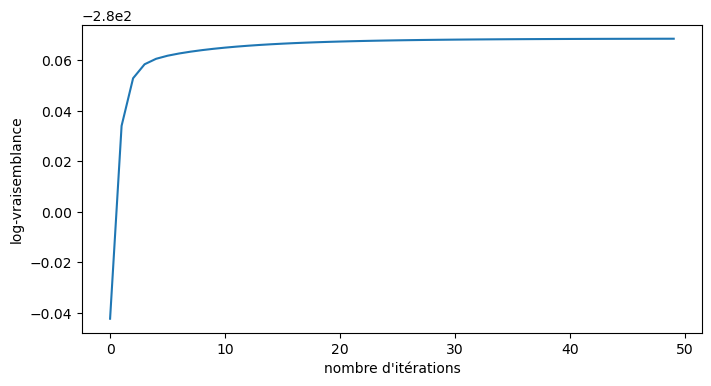

In [151]:
fig, axes = plt.subplots(figsize=(8,4))
axes.set_xlabel(r"nombre d'itérations")
axes.set_ylabel(r"log-vraisemblance")
axes.plot(liste_log_vraisemblance)

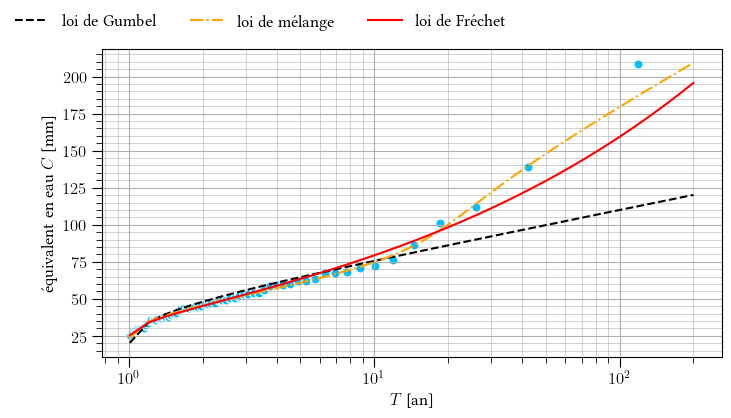

In [177]:
# loi GEV
(xi, mu, sigma) = calage_gev
xi = -xi
(mu_g, sigma_g) = calage_gumbel

solution_mélange = liste_solution[-1]
guess_quantile = np.mean(maxi_annuels_val)
if xi>0:
      nom_loi = 'Fréchet'
else:
      nom_loi = 'Weibull'
période = np.linspace(1.01,200,1000)
quantile_gev    = lambda T:  mu-sigma/xi*(1-(-np.log(1-1/T))**(-xi))
quantile_gumbel = lambda T: mu_g-sigma_g *np.log(-np.log(1-1/T) )

fig, axes = plt.subplots(figsize=(8,4))
axes.set_xlabel(r"$T$ [an]")
axes.set_ylabel(r"équivalent en eau $C$ [mm]")
axes.grid()
axes.grid(which='minor', color='grey', linestyle='-', alpha=0.5,linewidth=0.5)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
axes.tick_params(which='major', length=7)
axes.tick_params(which='minor', length=4)
plt.xscale('symlog', linthresh=1 )



quantiles_mélange = [mélange_quantile(T, *solution_mélange,guess_quantile) for T in période]
axes.semilogx(période,quantile_gumbel(période),'--',color='black' , label = "loi de Gumbel")
axes.semilogx(période,quantiles_mélange,'-.',color='orange' , label = "loi de mélange")
axes.semilogx(période,quantile_gev(période),'-',color='red' , label = "loi de "+nom_loi)

Tracer_maxi(maxi_annuels_val,axes)
fig.legend(loc="upper left",ncol=3,frameon=False)
fig.savefig('mixture.png',dpi=300,bbox_inches='tight')

In [148]:
 
l_g   = np.array([np.log(LVE_pdf(maxi_annuels_val[i],mu_g, sigma_g,0)) for i in range(n)]).sum()
l_lve = np.array([np.log(LVE_pdf(maxi_annuels_val[i],mu, sigma,xi)) for i in range(n)]).sum()
l_mel = liste_log_vraisemblance[-1]

tableau_résultat=[
    ['','Gumbel','LVE','mélange'],
    ['k','2','3','5'],
    [r'$\ell$',l_g,l_lve,l_mel],
    ['AIC',2*2-2*l_g,2*3-2*l_lve,2*5-2*l_mel]
]
print(tabulate(tableau_résultat))

------  ------------------  ------------------  ------------------
        Gumbel              LVE                 mélange
k       2                   3                   5
$\ell$  -287.1458496071662  -280.2048330517609  -279.9315048121764
AIC     578.2916992143324   566.4096661035218   569.8630096243528
------  ------------------  ------------------  ------------------
